In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [4]:
def matrice_raideur(elements,coordinates):
#########################################################################
# Fonction de calcul de la matrice raideur pour un triangle
# à partir des formules données à l'énoncé
#
# Entrees:
# elements : vecteur a trois colonnes contenant les indices des trois sommets
# du triangle donné
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
#
# Sorties : 
# Mat : La matrice de raideur élementaire relative au triangle
#########################################################################
    p1 = coordinates[elements[0],:]
    p2 = coordinates[elements[1],:]
    p3 = coordinates[elements[2],:]
    p = [p1,p2,p3]
    alpha = (p2[0]-p1[0])*(p3[1]-p1[1]) - (p2[1]-p1[1])*(p3[0]-p1[0])
    Mat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            dni = (1/alpha) * np.array([[p[((i+1)%3)][1] - p[((i+2)%3)][1]] , [p[((i+2)%3)][0] - p[((i+1)%3)][0]]])
            dnj = (1/alpha) * np.array([[p[((j+1)%3)][1] - p[((j+2)%3)][1]] , [p[((j+2)%3)][0] - p[((j+1)%3)][0]]])
            Mat[i,j] = (alpha/2) * np.matmul(np.transpose(dni),dnj)
    return Mat

In [5]:
def Assemblage_matrice_raideur(elements3, coordinates, n):
#########################################################################
# Fonction d'assemblage de la matrice raideur pour les éléments des 
# triangles de discrétisation
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
#
# Sorties : 
# A : La matrice raideur
#########################################################################
    npoin = n*n
    A = np.zeros((npoin,npoin))
    for elements in elements3:
        Mat = matrice_raideur(elements,coordinates)
        for i in range(3):
            for j in range(3):
                A[elements[i]][elements[j]] += Mat[i][j]
    return A

In [6]:
def vecteur_second_membre(elements,coordinates,f):
#########################################################################
# Fonction de calcul du vecteur second membre élémentaire
#
# Entrees:
# elements : vecteur a trois colonnes contenant les indices des trois sommets
# du triangle donné
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# f : la fonction f défini à l'équation (1) dans l'énoncé
#
# Sorties : 
# Le vecteur second memebre élementaire relative au triangle
#########################################################################
    p1 = coordinates[elements[0],:]
    p2 = coordinates[elements[1],:]
    p3 = coordinates[elements[2],:]
    alpha = (p2[0]-p1[0])*(p3[1]-p1[1]) - (p2[1]-p1[1])*(p3[0]-p1[0])
    g = (p1+p2+p3)/3
    return alpha*f(g[0],g[1])/6

In [7]:
def Assemblage_vecteur_second_membre(elements3, coordinates, n, f):
#########################################################################
# Fonction d'assemblage du vecteur second membre pour les éléments des 
# triangles de discrétisation
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
# f : la fonction f défini à l'équation (1) dans l'énoncé
#
# Sorties : 
# b : Le vecteur second membre
#########################################################################
    npoin = n*n
    b = np.zeros((npoin,1))
    for elements in elements3:
        bi = vecteur_second_membre(elements,coordinates,f)
        for i in range(3):
            b[elements[i]] += bi
    return b

In [8]:
# Définition des fonctions qu'on aura besoin pour tester nos fonctions
def f(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y) # u = np.sin(np.pi*x)*np.sin(np.pi*y)/(2*np.pi**2)

def u(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)/(2*np.pi**2)

def ud():
    return 0

def g(x,y):
    return 0

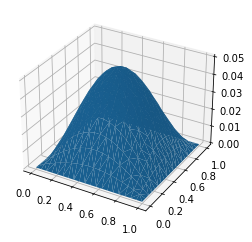

L'erreur de cette méthode est : 0.0018467861774934314


In [10]:
# Définir n et appeler les fonctions d'assemblage de matrice raideur et vecteur second membre
n = 20
coordinates, elements3,dirichlet, neumann = maillage(n)
A = Assemblage_matrice_raideur(elements3, coordinates, n)
b = Assemblage_vecteur_second_membre(elements3, coordinates, n, f)

A_copie = np.copy(A)     
b_copie = np.copy(b)

# enlever les lignes et les colonnes pour la matrice raideur, et les lignes pour le vecteur
# second membre qui se trouvent sur les indices de dirichlet
j=0
for i in range(n**2):
    if [i] in dirichlet:
        A_copie = np.delete(A_copie,i-j,axis=0)
        A_copie = np.delete(A_copie,i-j,axis=1)
        b_copie = np.delete(b_copie,i-j,axis=0)
        j += 1

# Résolution du système
u_result = ssl.spsolve(A_copie,b_copie)

# On attribut 0 à u_result dans les indices de dirichlet
for [i] in sorted(dirichlet):
    v = np.append(u_result[:i],[0])
    u_result = np.append(v,u_result[i:])
    
show(coordinates, u_result)

# On calcule et on affiche l'erreur entre u_result et u attendu
erreur = np.linalg.norm(u_result-u(coordinates[:,0],coordinates[:,1]))
print("L'erreur de cette méthode est :", erreur)

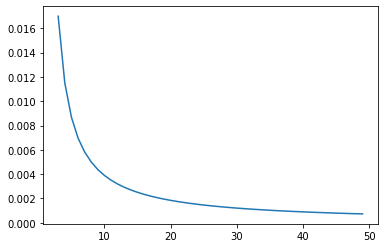

In [55]:
# Le même programme qu'auparavant dans une boucle for dont l'indice est n qui varie entre 3 et 50
# et ceci pour qu'on puisse voir l'évolution de l'erreur en fonction de n

nbr_maillage = []
erreurs = []

for n in range (3,50):
    coordinates, elements3,dirichlet, neumann = maillage(n)
    A = Assemblage_matrice_raideur(elements3, coordinates, n)
    b = Assemblage_vecteur_second_membre(elements3, coordinates, n, f)

    A_copie = np.copy(A)     
    b_copie = np.copy(b)

    j=0
    for i in range(n**2):
        if [i] in dirichlet:
            A_copie = np.delete(A_copie,i-j,axis=0)
            A_copie = np.delete(A_copie,i-j,axis=1)
            b_copie = np.delete(b_copie,i-j,axis=0)
            j += 1

    u_result = ssl.spsolve(A_copie,b_copie)

    copie_dirichlet = sorted(dirichlet)

    for [i] in copie_dirichlet:
        v = np.append(u_result[:i],[0])
        u_result = np.append(v,u_result[i:])

    erreur = np.linalg.norm(u_result-u(coordinates[:,0],coordinates[:,1]))
    erreurs.append(erreur)
    nbr_maillage.append(n)
                            
plt.plot(nbr_maillage, erreurs)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [12]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
#dds=np.array([1,5,2,15,4,6,7,8,9,10,11,0]).astype(int)
#nns=np.array([]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [13]:
def matrice_raideur4(elements,coordinates):
#########################################################################
# Fonction de calcul de la matrice raideur pour un carré
# à partir des formules énoncé dans le rapport
#
# Entrees:
# elements : vecteur a quatre colonnes contenant les indices des quatre sommets
# du carré donné
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
#
# Sorties : 
# A : La matrice de raideur élementaire relative au carré
#########################################################################
    p1 = coordinates[elements[0],:]
    p2 = coordinates[elements[1],:]
    p4 = coordinates[elements[3],:]
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    x4 = p4[0]
    y4 = p4[1]
    
    A = np.zeros((4,4))
    J = np.array([[x2-x1,x4-x1],[y2-y1,y4-y1]])
    alpha = np.linalg.norm(J)
    N = np.linalg.inv(np.matmul(np.transpose(J),J))
    N1 = N[0,0]
    N2 = N[0,1]
    N4 = N[1,1]

    A = np.zeros((4,4))
    A[0,0] = 2*N1+3*N2+2*N4
    A[1,1] = 2*N1-3*N2+2*N4
    A[2,2] = 2*N1+3*N2+2*N4
    A[3,3] = 2*N1-3*N2+3*N4
    A[0,1] = -2*N1+N4
    A[1,0] = -2*N1+N4
    A[0,2] = -N1-3*N2-N4
    A[2,0] = -N1-3*N2-N4
    A[0,3] = N1-2*N4
    A[3,0] = N1-2*N4
    A[1,2] = N1-2*N4
    A[2,1] = N1-2*N4
    A[1,3] = -N1+3*N2-N4
    A[3,1] = -N1+3*N2-N4
    A[2,3] = -2*N1+N4
    A[3,2] = -2*N1+N4
    A = (alpha/6)*A
    return A

In [14]:
def Assemblage_matrice_raideur4(elements4, coordinates, n):
#########################################################################
# Fonction d'assemblage de la matrice raideur pour les éléments des 
# carrés de discrétisation
#
# Entrees:
# elements4 : matrice a quatre colonnes contenant les elements carrés
# de la discretisation, identifies par les indices de leurs quatre
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
#
# Sorties : 
# A : La matrice raideur
#########################################################################
    npoin = n*n
    A = np.zeros((npoin,npoin))
    for elements in elements4:
        Mat = matrice_raideur4(elements,coordinates)
        for i in range(4):
            for j in range(4):
                A[elements[i]][elements[j]] += Mat[i][j]
    return A

In [15]:
def vecteur_second_membre4(elements,coordinates,f):
#########################################################################
# Fonction de calcul du vecteur second membre élémentaire
#
# Entrees:
# elements : vecteur a quatre colonnes contenant les indices des quatre sommets
# du carré donné
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# f : la fonction f défini à l'équation (1) dans l'énoncé
#
# Sorties : 
# Le vecteur second memebre élementaire relative au carré
#########################################################################
    p1 = coordinates[elements[0],:]
    p2 = coordinates[elements[1],:]
    p3 = coordinates[elements[2],:]
    p4 = coordinates[elements[3],:]
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    x4 = p4[0]
    y4 = p4[1]
    J = np.array([[x2-x1,x4-x1],[y2-y1,y4-y1]])
    alpha = np.linalg.norm(J)
    g = (p1+p2+p3+p4)/4
    return alpha*f(g[0],g[1])/4

In [16]:
def Assemblage_vecteur_second_membre4(elements4, coordinates, n, f):
#########################################################################
# Fonction d'assemblage du vecteur second membre pour les éléments des 
# carrés de la discrétisation
#
# Entrees:
# elements4 : matrice a quatre colonnes contenant les elements carrés
# de la discretisation, identifies par les indices de leurs quatre
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
# f : la fonction f défini à l'équation (1) dans l'énoncé
#
# Sorties : 
# b : Le vecteur second membre
#########################################################################
    npoin = n*n
    b = np.zeros((npoin,1))
    for elements in elements4:
        bi = vecteur_second_membre4(elements,coordinates,f)
        for i in range(4):
            b[elements[i]] += bi
    return b

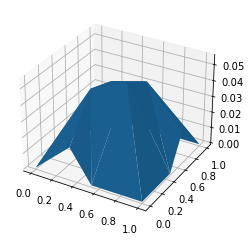

L'erreur de cette méthode est : 0.03408952494743491


In [17]:
# Définir n et appeler les fonctions d'assemblage de matrice raideur et vecteur second membre
# sur les triangles et les carrés et on somme les deux (maillage *mixte*)
n =4

A3 = Assemblage_matrice_raideur(e3, ccs, n)
A4 = Assemblage_matrice_raideur4(e4, ccs, n)
A = A3 + A4

b3 = Assemblage_vecteur_second_membre(e3, ccs, n, f)
b4 = Assemblage_vecteur_second_membre4(e4, ccs, n, f)
b = b3 + b4

# On applique la condition de Neumann au vecteur second membre
for [i,j] in nns:
    barycentre = (ccs[i]+ccs[j])/2
    l = np.linalg.norm(ccs[i]-ccs[j])
    k = 0.5*l*g(barycentre[0],barycentre[1])
    b[i] += k
    b[j] += k

A_copie = np.copy(A)
b_copie = np.copy(b)

# enlever les lignes et les colonnes pour la matrice raideur, et les lignes pour le vecteur
# second membre qui se trouvent sur les indices de dirichlet
j=0
for i in range(n**2):
    if i in dds:
        A_copie = np.delete(A_copie,i-j,axis=0)
        A_copie = np.delete(A_copie,i-j,axis=1)
        b_copie = np.delete(b_copie,i-j,axis=0)
        j += 1

# Résolution du système
u_result = ssl.spsolve(A_copie,b_copie)

# On attribut la valeur de la fonction ud (0 dans notre cas) à u_result dans les indices de dirichlet
for i in sorted(dds):
    v = np.append(u_result[:i],[ud()])
    u_result = np.append(v,u_result[i:])

show(ccs, u_result)

# On calcule et on affiche l'erreur entre u_result et u attendu
erreur = np.linalg.norm(u_result-u(ccs[:,0],ccs[:,1]))
print("L'erreur de cette méthode est :", erreur)

**Compléments  :  un nouveau terme dans l'EDP**

In [18]:
def matrice_raideur_comp(elements,coordinates, c0):
#########################################################################
# Fonction de calcul de la matrice raideur pour un triangle
# à partir des formules données à l'énoncé plus la formule calculé dans le
# rapport qui dépend du nouveau terme ajouté
#
# Entrees:
# elements : vecteur a trois colonnes contenant les indices des trois sommets
# du triangle donné
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# c0 : la constante défini dans l'équation (8) de l'énoncé
#
# Sorties : 
# Mat : La matrice de raideur élementaire relative au triangle
#########################################################################
    p1 = coordinates[elements[0],:]
    p2 = coordinates[elements[1],:]
    p3 = coordinates[elements[2],:]
    p = [p1,p2,p3]
    alpha = (p2[0]-p1[0])*(p3[1]-p1[1]) - (p2[1]-p1[1])*(p3[0]-p1[0])
    Mat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            dni = (1/alpha) * np.array([[p[((i+1)%3)][1] - p[((i+2)%3)][1]] , [p[((i+2)%3)][0] - p[((i+1)%3)][0]]])
            dnj = (1/alpha) * np.array([[p[((j+1)%3)][1] - p[((j+2)%3)][1]] , [p[((j+2)%3)][0] - p[((j+1)%3)][0]]])
            Mat[i,j] = (alpha/2) * np.matmul(np.transpose(dni),dnj)
            if i == j:
                Mat[i,j] += (c0*alpha)/12
            else:
                Mat[i,j] += (c0*alpha)/24
    return Mat

In [19]:
def Assemblage_matrice_raideur_comp(elements3, coordinates, n, c0):
#########################################################################
# Fonction d'assemblage de la matrice raideur pour les éléments des 
# triangles de discrétisation
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
# c0 : la constante défini dans l'équation (8) de l'énoncé
#
# Sorties : 
# A : La matrice raideur
#########################################################################
    npoin = n*n
    A = np.zeros((npoin,npoin))
    for elements in elements3:
        Mat = matrice_raideur_comp(elements,coordinates, c0)
        for i in range(3):
            for j in range(3):
                A[elements[i]][elements[j]] += Mat[i][j]
    return A

In [20]:
def vecteur_second_membre_comp(elements,coordinates,f):
#########################################################################
# Fonction de calcul du vecteur second membre élémentaire
#
# Entrees:
# elements : vecteur a trois colonnes contenant les indices des trois sommets
# du triangle donné
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# f : la fonction f défini à l'équation (8) dans l'énoncé
#
# Sorties : 
# Le vecteur second memebre élementaire relative au triangle
#########################################################################
    p1 = coordinates[elements[0],:]
    p2 = coordinates[elements[1],:]
    p3 = coordinates[elements[2],:]
    alpha = (p2[0]-p1[0])*(p3[1]-p1[1]) - (p2[1]-p1[1])*(p3[0]-p1[0])
    g = (p1+p2+p3)/3
    return alpha*f(g[0],g[1])/6

In [21]:
def Assemblage_vecteur_second_membre_comp(elements3, coordinates, n, f):
#########################################################################
# Fonction d'assemblage du vecteur second membre pour les éléments des 
# triangles de discrétisation
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
# f : la fonction f défini à l'équation (1) dans l'énoncé
#
# Sorties : 
# b : Le vecteur second membre
#########################################################################
    npoin = n*n
    b = np.zeros((npoin,1))
    for elements in elements3:
        bi = vecteur_second_membre_comp(elements,coordinates,f)
        for i in range(3):
            b[elements[i]] += bi
    return b

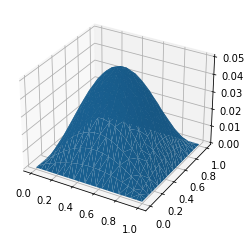

L'erreur de cette méthode est : 0.0014172105365576621


In [22]:
# Définition des fonctions modifiées dont on aura besoin pour nos calculs (notamment f)
def f(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y) + c0*np.sin(np.pi*x)*np.sin(np.pi*y)/(2*np.pi**2)

def ud(x,y):
    return 0

def u(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)/(2*np.pi**2)

# Définir n et appeler les fonctions d'assemblage de matrice raideur et vecteur second membre
n = 20
c0 = 3
coordinates, elements3,dirichlet, neumann = maillage(n)
A = Assemblage_matrice_raideur_comp(elements3, coordinates, n, c0)
b = Assemblage_vecteur_second_membre_comp(elements3, coordinates, n, f)

A_copie = np.copy(A)     
b_copie = np.copy(b)

# enlever les lignes et les colonnes pour la matrice raideur, et les lignes pour le vecteur
# second membre qui se trouvent sur les indices de dirichlet
j=0
for i in range(n**2):
    if [i] in dirichlet:
        A_copie = np.delete(A_copie,i-j,axis=0)
        A_copie = np.delete(A_copie,i-j,axis=1)
        b_copie = np.delete(b_copie,i-j,axis=0)
        j += 1

# Résolution du système
u_result = ssl.spsolve(A_copie,b_copie)

# On attribut 0 à u_result dans les indices de dirichlet
for [i] in sorted(dirichlet):
    v = np.append(u_result[:i],[0])
    u_result = np.append(v,u_result[i:])
    
show(coordinates, u_result)

# On calcule et on affiche l'erreur entre u_result et u attendu
erreur = np.linalg.norm(u_result-u(coordinates[:,0],coordinates[:,1]))
print("L'erreur de cette méthode est :", erreur)

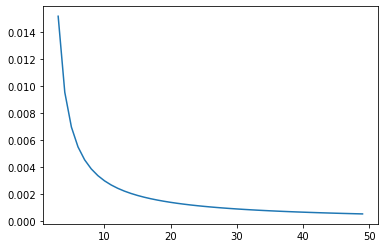

In [80]:
# Le même programme qu'auparavant dans une boucle for dont l'indice est n qui varie entre 3 et 50
# et ceci pour qu'on puisse voir l'évolution de l'erreur en fonction de n
nbr_maillage = []
erreurs = []

for n in range (3,50):
    c0 = 3

    coordinates, elements3,dirichlet, neumann = maillage(n)
    A = Assemblage_matrice_raideur_comp(elements3, coordinates, n, c0)
    b = Assemblage_vecteur_second_membre_comp(elements3, coordinates, n, f)

    A_copie = np.copy(A)     
    b_copie = np.copy(b)

    j=0
    for i in range(n**2):
        if [i] in dirichlet:
            A_copie = np.delete(A_copie,i-j,axis=0)
            A_copie = np.delete(A_copie,i-j,axis=1)
            b_copie = np.delete(b_copie,i-j,axis=0)
            j += 1

    u_result = ssl.spsolve(A_copie,b_copie)

    copie_dirichlet = sorted(dirichlet)

    for [i] in copie_dirichlet:
        v = np.append(u_result[:i],[0])
        u_result = np.append(v,u_result[i:])

    erreur = np.linalg.norm(u_result-u(coordinates[:,0],coordinates[:,1]))
    erreurs.append(erreur)
    nbr_maillage.append(n)
                            
plt.plot(nbr_maillage, erreurs)